In [2]:
import glob
import functools
from typing import List, Tuple
from datasets import load_dataset
import torch
import torchvision
import pandas as pd
import albumentations
import evaluate
from torch.utils.data import DataLoader
from torchmetrics.detection import MeanAveragePrecision
from transformers import DetrForObjectDetection, DetrImageProcessor
from transformers import Trainer, DetrConfig
from transformers import TrainingArguments
from custom_detr import *
from helper import *

In [3]:
checkpoint = "facebook/detr-resnet-50"
json_path = 'new/test_ann.json'
train_path = 'new/train/'
val_path = 'new/val/'
test_path = 'new/test/'
mixup_path = 'new/mixup/'
output_dir = 'detr_ciou_finetuned_pvt2/'

In [4]:
image_processor = DetrImageProcessor.from_pretrained(checkpoint)

id2label = {0: 'penguin', 1: 'turtle'}
label2id = {v: k for k, v in id2label.items()}

# Load dataset
train_dataset = load_dataset(train_path)['train']
val_dataset = load_dataset(val_path)['train']
test_dataset = load_dataset(test_path)['train']

# Load annotations
train_annotations = pd.read_json('new/train_annotations')
val_annotations = pd.read_json('new/valid_annotations')
test_annotations = pd.read_json('new/test_annotations')

# Add mixup
file = open('new/mixup_annotation.json', 'r')
json_data = json.load(file)
mixup_annotation = pd.json_normalize(json_data)
mixup_dataset = load_dataset(mixup_path)['train']

# Use device
device = 'cpu'
if torch.backends.mps.is_available():
    device = 'mps'
if torch.cuda.is_available():
    device = 'cuda'
device

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Resolving data files:   0%|          | 0/4500 [00:00<?, ?it/s]

Found cached dataset imagefolder (/Users/weixian/.cache/huggingface/datasets/imagefolder/train-40745cd062c8d0d9/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Found cached dataset imagefolder (/Users/weixian/.cache/huggingface/datasets/imagefolder/val-9a2c40b0f8b4f677/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

Found cached dataset imagefolder (/Users/weixian/.cache/huggingface/datasets/imagefolder/test-9dda102c6b24b429/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2250 [00:00<?, ?it/s]

Found cached dataset imagefolder (/Users/weixian/.cache/huggingface/datasets/imagefolder/mixup-8aaa051dbcf54fde/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

'mps'

Resize and do random augmentation in images

In [5]:
# Resize and further augmentation to improve performance
transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=["category"]),
)

transform_aug_ann_val = functools.partial(transform_aug_ann, annotations=val_annotations, transform=transform,
                                          image_processor=image_processor)

def transform_ann(example):
    file_name: str = example["image"][0].filename.split('/')[-1]
    if not file_name.startswith('mixup_'):
        return transform_aug_ann(example, train_annotations, transform, image_processor)
    else:
        return transform_mixup_ann(example, mixup_annotation, transform, image_processor)


In [6]:
# Apply augmentation
#train_dataset = concatenate_datasets([train_dataset, mixup_dataset])
train_dataset = train_dataset.with_transform(transform_ann)
#mixup_dataset = mixup_dataset.with_transform(transform_mix_ann)
val_dataset = val_dataset.with_transform(transform_aug_ann_val)
train_dataset[0]

Parameter 'transform'=<function transform_ann at 0x110daab60> of the transform datasets.arrow_dataset.Dataset.set_format couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


{'pixel_values': tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.640

In [7]:
# Get pixel values and pixel mask and labels for batch processing
collate_fn_default = functools.partial(collate_fn, image_processor=image_processor)
collate_fn_prob = functools.partial(collate_fn_onehot, image_processor=image_processor,
                                    mixup_annotation=mixup_annotation)

``model`` is default implement of detr, 
and ``model_v2`` is our custom_detr, aims to apply different iou functions and mixup in the backend.

In [9]:
detr_config = DetrConfig(id2label=id2label,
                         label2id=label2id,
                         num_labels=2,
                         )

# DEFAULT DETR
# model = DetrForObjectDetection.from_pretrained(
#     checkpoint,
#     ignore_mismatched_sizes=True,
#     config=detr_config
# )
# model.model.freeze_backbone()

# Custom DETR (CIoU and DIoU)
model_v2 = DetrForObjectDetection_v2.from_pretrained(
    checkpoint,
    ignore_mismatched_sizes=True,
    config=detr_config,
    iou_mode='ciou'
)

Some weights of DetrForObjectDetection_v2 were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([3, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading tensorboard so we can monitor the training loss from dashboard.

In [46]:
%load_ext tensorboard
#reload_ext tensorboard
%tensorboard --logdir 'detr_ciou_finetuned_pvt2/runs'

Launching TensorBoard...

``lr``: 3e-5
``weight decay``: 1e-4
``warm up ratio``: 0.1
``epochs``: 5

In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=8,
    num_train_epochs=5,
    save_steps=100,
    logging_steps=100,
    learning_rate=3e-5,
    weight_decay=1e-4,
    save_total_limit=2,  # 1,
    save_strategy="steps",  # "no",
    load_best_model_at_end=True,  # False,
    remove_unused_columns=False,
    use_mps_device=True if device == 'mps' else False,
    # no_cuda=True,
    warmup_ratio=0.1,
    # warmup_steps=50,
    # metric_for_best_model='eval_loss',
    # greater_is_better=False,
    evaluation_strategy='steps',
)

trainer = Trainer(
    model=model_v2,
    args=training_args,
    data_collator=collate_fn_default,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics
)

trainer.train()

/Users/weixian/Documents/9517/penguins-and-turtle-classifier/.env/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/Users/weixian/Documents/9517/penguins-and-turtle-classifier/.env/lib/python3.11/site-packages/torch/autograd/__init__.py:204: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step,Training Loss,Validation Loss,Loss Ce,Loss Bbox,Loss Iou,Cardinality Error
100,1.589400,1.218069,0.769308,0.049140,0.096167,16.571428
200,0.987400,0.802797,0.351843,0.050075,0.096197,1.000000
300,0.882800,0.795215,0.341772,0.053571,0.105134,1.000000
400,0.704900,0.620899,0.285100,0.033657,0.074668,1.000000
500,0.762900,0.686917,0.276307,0.042130,0.090340,1.000000
600,0.684100,0.678363,0.235595,0.047918,0.093072,1.000000
700,0.705800,0.625310,0.202330,0.050606,0.093675,0.428571
800,0.647200,0.624227,0.161333,0.057535,0.096631,0.285714
900,0.647400,0.633469,0.167352,0.062774,0.108393,0.000000
1000,0.617200,0.644301,0.168240,0.066908,0.116563,0.000000


In [10]:
output_dir = 'detr_ciou_finetuned_pvt1/'
checkpoint_v2 = output_dir + 'checkpoint-5100'
image_processor = DetrImageProcessor.from_pretrained(checkpoint_v2)
model = DetrForObjectDetection_v2.from_pretrained(checkpoint_v2)
model.to(device)

DetrForObjectDetection_v2(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   

In [8]:
#save_eval_image(test_path, image_processor, device, test_annotations, model)

100%|██████████| 73/73 [00:08<00:00,  8.66it/s]


Detected turtle with confidence 0.381 at location [144.37, 122.15, 534.11, 520.88]
Detected turtle with confidence 0.547 at location [145.37, 123.32, 510.53, 522.77]
Detected turtle with confidence 0.476 at location [280.93, 267.15, 329.84, 381.81]


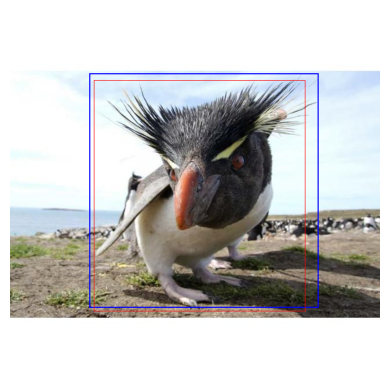

In [24]:
inference(model, device, image_processor, to_file_name(20, test_path), test_annotations)

Detection Performance mu: 4.713, std: 7.536
IOU mu: 0.949, std: 0.053


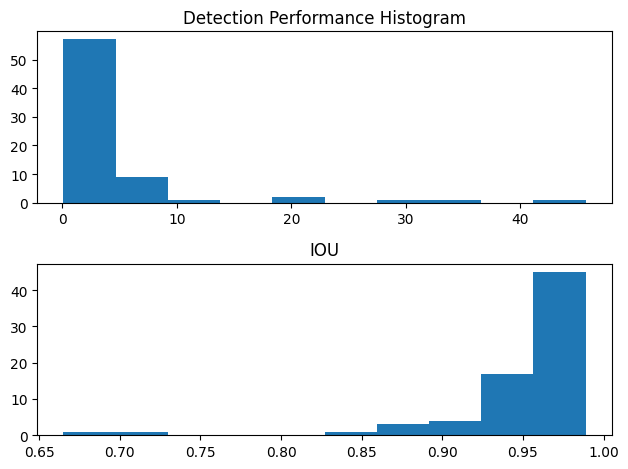

In [11]:
get_performance(model, device, image_processor, test_annotations, test_path)